In [7]:
from matplotlib import pyplot as plt
import time
import arviz as az
import numpy as np
import pymc as pm

rng = np.random.default_rng(1690)

In [8]:
from scipy.integrate import odeint

X0 = [95,5,0.0]
# size of data
size = 200
# time lapse
ts = 20
t = np.linspace(0.0, ts, size)
b = 3
g = 1

# SIR
def dX_dt(X, t, b, g):
    """Return the growth rate of fox and rabbit populations."""

    return np.array([-b*X[0]*X[1]/sum(X),b*X[0]*X[1]/sum(X) - g*X[1], g*X[1]])


# simulator function
def competition_model(rng, b, g, size=None):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(b,g))

In [9]:
def real_sir(X0,mu,beta,gamma,tmax,tstep): #define a SIR Model with births and deaths. There are 6 possible events here: birth; S death; I death; R death; infection; recovery
    """
    :param X0: Initial Conditions for reality
    :param mu: Birth/death rate
    :param beta: Infection rate
    :param gamma: Recovery rate
    :param tmax: length of simulation
    :return: X(tmax), times
    """

    #initilise the required arrays

    t = 0.0
    X = np.array(X0)
    sol = np.array([X0])
    counter = 0.0


    # Run
    while(t<tmax):
        N = X[0] + X[1] + X[2]
        Rt = (beta*X[0]*X[1]/N)
        Rr = gamma*X[1]
        Rds = (mu*X[0])
        Rdi = (mu*X[1])
        Rdr = (mu*X[2])
        Rb = (mu*N)
        Rtotal = Rt + Rr + Rds + Rdr + Rdi + Rb
        if Rtotal != 0:
            u = rng.exponential(1/Rtotal)
            t = t + u
            counter += u
            #times = np.append(times,t)

            # chose the event

            z = rng.random()
            P = z*Rtotal
            fil = np.array([Rt,Rt+Rr,Rt+Rr+Rds,Rt+Rr+Rds+Rdi,Rt+Rr+Rds+Rdi+Rdr,Rt+Rr+Rds+Rdi+Rdr+Rb])
            event = min(i for i in fil if i >= P)
            if event == fil[0]:
                X = X + [-1,1,0]

            elif event == fil[1]:
                X = X + [0,-1,1]
            elif event == fil[2]:
                X = X + [-1,0,0]
            elif event == fil[3]:
                X = X + [0,-1,0]
            elif event == fil[4]:
                X = X + [0,0,-1]
            else:
                X = X + [1,0,0]
        else:
            r_t = tmax - t
            r_step = int(r_t/tstep)
            for i in range(r_step):
                sol = np.append(sol,[X],axis=0)
            return sol
        while counter >= tstep:
            counter = counter - tstep
            sol = np.append(sol,[X],axis=0)
    return sol

In [11]:
X0 = [95,5,0]
beta = 3
gamma = 1
mu = 0
tmax = 20
tstep = 0.1
rng = np.random.default_rng(1690)
start_time = time.time()
reality = real_sir(X0, mu, beta, gamma, tmax,tstep)
print(f"Reality took {time.time() - start_time} seconds to run!")
times = np.arange(0,tmax,tstep)
#print(reality)

Reality took 0.003058910369873047 seconds to run!


In [12]:
start_time = time.time()
with pm.Model() as model_lv:
    b = pm.HalfNormal("b", 1.0)
    g = pm.HalfNormal("g", 1.0)

    sim = pm.Simulator("sim", competition_model, params=(b, g), epsilon=10, observed=reality)

    idata_lv = pm.sample_smc(progressbar=False)
print(f"Reality took {time.time() - start_time} seconds to fit!")

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Reality took 850.4466264247894 seconds to fit!


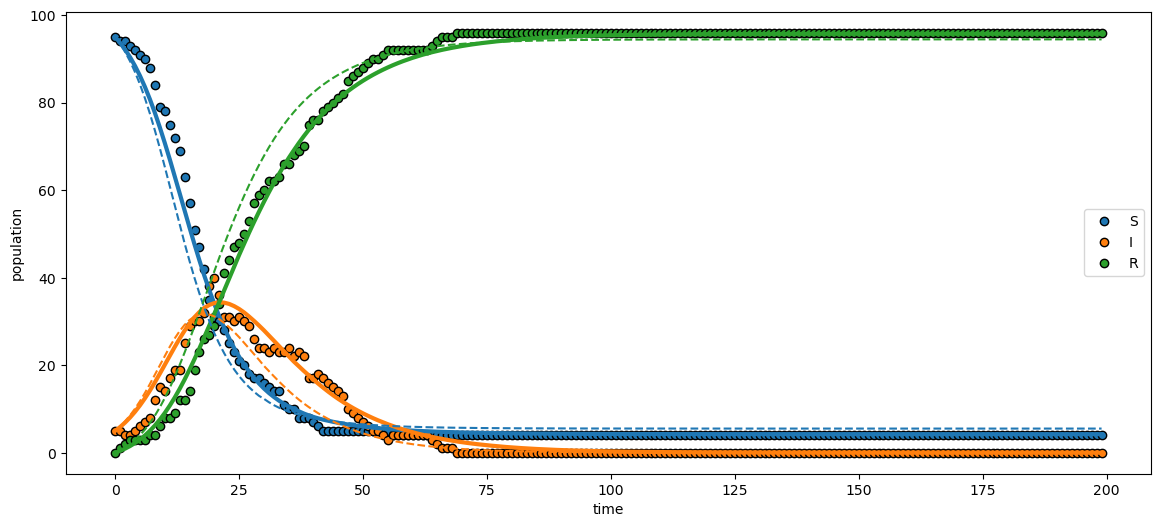

In [17]:
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(reality[:, 0], "o", label="S", c="C0", mec="k")
ax.plot(reality[:, 1], "o", label="I", c="C1", mec="k")
ax.plot(reality[:, 2], "o", label="R", c="C2", mec="k")
ax.plot(competition_model(None, posterior["b"].mean(), posterior["g"].mean()), linewidth=3)
#for i in np.random.randint(0, size, 75):
sim = competition_model(None, 3, 1)
ax.plot(sim[:, 0], alpha=1, c="C0", linestyle = "--")
ax.plot(sim[:, 1], alpha=1, c="C1", linestyle = "--")
ax.plot(sim[:, 2], alpha=1, c="C2", linestyle = "--")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

array([<Axes: title={'center': 'b'}>, <Axes: title={'center': 'g'}>],
      dtype=object)

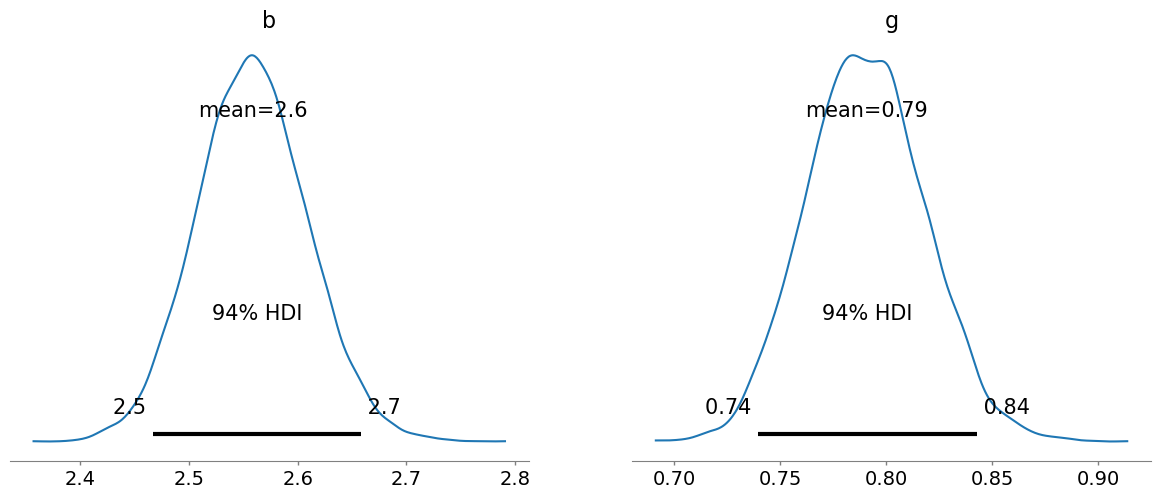

In [14]:
az.plot_posterior(idata_lv)